In [11]:
import sys

sys.path.append('../..') # Add backtester base dir to $PYTHONPATH

In [12]:
%config InlineBackend.figure_format="retina"
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

In [13]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest

In [16]:
# Cleaned up data
data = HistoricalOptionsData("allspx/options_data_v2_pruned_compressed.h5", key="/SPX")
schema = data.schema

In [17]:
data._data = data._data[(data._data['quotedate'] >= '2006-12-06') & (data._data['quotedate'] <= '2015-08-21')]

We run the backtest on the date range above to compare with [this backtest.](http://dtr-trading.blogspot.com/p/spx-straddle-articles.html) We do the comparison with a [short (ATM) straddle](https://www.investopedia.com/terms/s/shortstraddle.asp) 45 DTE. Essentially the strategy consists of selling both a call and a put with (approximately) the same strike and expiration date, profiting if the underlying asset's price does not move very much. 

In [18]:
# Short ATM straddle
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2])
# Exit thresholds: we exit if the loss or profit on the investment on an entry is greater than 25%.
short_straddle.exit_thresholds = (0.25, 0.25)

In [19]:
bt = Backtest()
bt.strategy = short_straddle
bt.data = data
bt.stop_if_broke = False

In [20]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:03:56


leg_1                                                     \
                contract underlying expiration  type  strike     cost order   
0     SXZ070120C01435000        SPX 2007-01-20  call  1435.0  -1110.0   STO   
1     SXZ070120C01440000        SPX 2007-01-20  call  1440.0   -840.0   STO   
2     SXZ070120C01450000        SPX 2007-01-20  call  1450.0   -520.0   STO   
3     SXZ070120C01455000        SPX 2007-01-20  call  1455.0   -410.0   STO   
4     SXZ070120C01455000        SPX 2007-01-20  call  1455.0    400.0   BTC   
...                  ...        ...        ...   ...     ...      ...   ...   
1329  SPX150821C01975000        SPX 2015-08-21  call  1975.0  10390.0   BTC   
1330  SPX150821C01965000        SPX 2015-08-21  call  1965.0  11390.0   BTC   
1331  SPX150821C01980000        SPX 2015-08-21  call  1980.0   9890.0   BTC   
1332  SPX150821C01985000        SPX 2015-08-21  call  1985.0   9390.0   BTC   
1333  SPX150918C02005000        SPX 2015-09-18  call  2005.0   5680.0   BTC   

                   leg_2                                                   \
                contract underlying expiration type  strike    cost order   
0     SXY070120P01355000        SPX 2007-01-20  put  1355.0  -460.0   STO   
1     SXY070120P01340000        SPX 2007-01-20  put  1340.0  -480.0   STO   
2     SXY070120P01345000        SPX 2007-01-20  put  1345.0  -460.0   STO   
3     SXY070120P01365000        SPX 2007-01-20  put  1365.0  -580.0   STO   
4     SXY070120P01365000        SPX 2007-01-20  put  1365.0   340.0   BTC   
...                  ...        ...        ...  ...     ...     ...   ...   
1329  SPX150821P01975000        SPX 2015-08-21  put  1975.0    20.0   BTC   
1330  SPX150821P01965000        SPX 2015-08-21  put  1965.0    20.0   BTC   
1331  SPX150821P01980000        SPX 2015-08-21  put  1980.0    20.0   BTC   
1332  SPX150821P01985000        SPX 2015-08-21  put  1985.0    25.0   BTC   
1333  SPX150918P02015000        SPX 2015-09-18  put  2015.0  3460.0   BTC   

       totals                     
         cost     qty       date  
0     -1570.0   637.0 2006-12-06  
1     -1320.0   758.0 2006-12-07  
2      -980.0  1021.0 2006-12-08  
3      -990.0  1011.0 2006-12-11  
4       740.0  1011.0 2006-12-18  
...       ...     ...        ...  
1329  10410.0    74.0 2015-08-19  
1330  11410.0    74.0 2015-08-19  
1331   9910.0    78.0 2015-08-19  
1332   9415.0    83.0 2015-08-19  
1333   9140.0    83.0 2015-08-20  

[1334 rows x 17 columns]

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


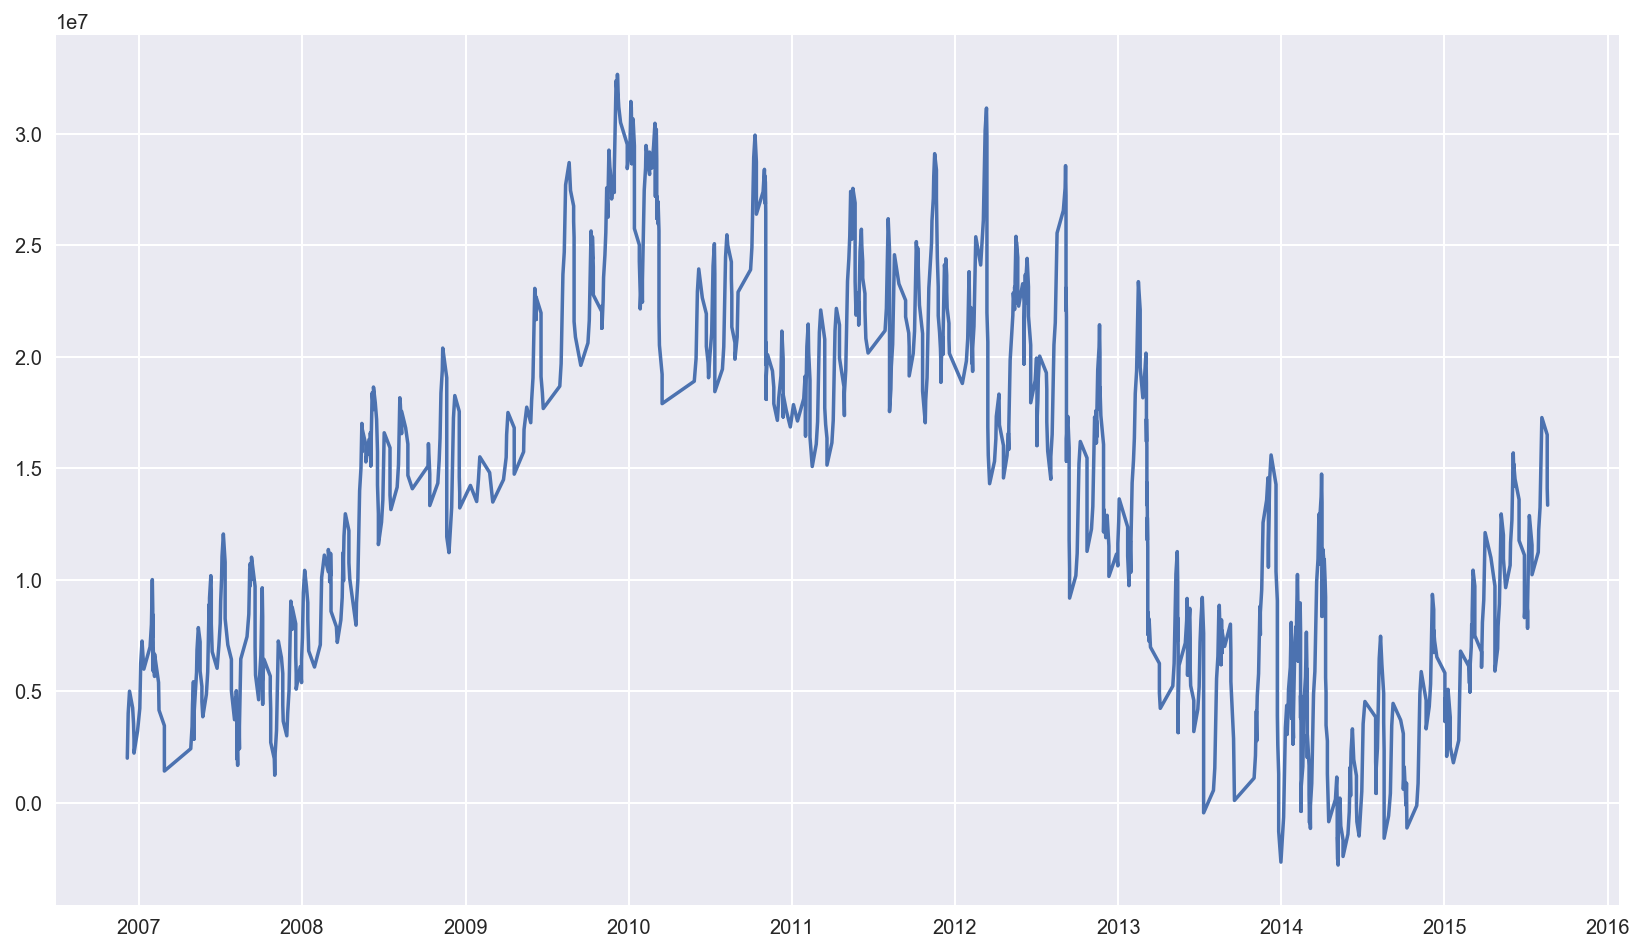

In [21]:
capital = short_straddle.initial_capital + (-bt.trade_log['totals']['cost'] * bt.trade_log['totals']['qty']).cumsum()
date = bt.trade_log['totals']['date']
plt.plot(date, capital);

We now run a [long (ATM) straddle](https://www.investopedia.com/terms/l/longstraddle.asp) 45 DTE. This is the opposite of the previous strategy, where we enter buying the contracts instead of selling, and therefore profit from big movements in the underlying asset's price. 

In [22]:
# Long (ATM) straddle
long_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg2.exit_filter = (schema.dte <= 2)

long_straddle.add_legs([leg1, leg2])
long_straddle.exit_thresholds = (0.25, 0.25)

In [23]:
bt = Backtest()
bt.strategy = long_straddle
bt.data = data
bt.stop_if_broke = False

In [24]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:03:47


leg_1                                                     \
                contract underlying expiration  type  strike     cost order   
0     SXZ070120C01435000        SPX 2007-01-20  call  1435.0   1230.0   BTO   
1     SXZ070120C01440000        SPX 2007-01-20  call  1440.0    930.0   BTO   
2     SXZ070120C01450000        SPX 2007-01-20  call  1450.0    570.0   BTO   
3     SXZ070120C01455000        SPX 2007-01-20  call  1455.0    480.0   BTO   
4     SXZ070120C01435000        SPX 2007-01-20  call  1435.0   -910.0   STC   
...                  ...        ...        ...   ...     ...      ...   ...   
1326  SPX150918C01975000        SPX 2015-09-18  call  1975.0  11190.0   BTO   
1327  SPX150821C01965000        SPX 2015-08-21  call  1965.0 -10830.0   STC   
1328  SPX150821C01955000        SPX 2015-08-21  call  1955.0 -11830.0   STC   
1329  SPX150918C02005000        SPX 2015-09-18  call  2005.0  -5460.0   STC   
1330  SPX150918C02000000        SPX 2015-09-18  call  2000.0  -5810.0   STC   

                   leg_2                                                   \
                contract underlying expiration type  strike    cost order   
0     SXY070120P01355000        SPX 2007-01-20  put  1355.0   550.0   BTO   
1     SXY070120P01340000        SPX 2007-01-20  put  1340.0   570.0   BTO   
2     SXY070120P01345000        SPX 2007-01-20  put  1345.0   550.0   BTO   
3     SXY070120P01365000        SPX 2007-01-20  put  1365.0   620.0   BTO   
4     SXY070120P01355000        SPX 2007-01-20  put  1355.0  -420.0   STC   
...                  ...        ...        ...  ...     ...     ...   ...   
1326  SPX150918P02045000        SPX 2015-09-18  put  2045.0  2720.0   BTO   
1327  SPX150821P01965000        SPX 2015-08-21  put  1965.0   -10.0   STC   
1328  SPX150821P01955000        SPX 2015-08-21  put  1955.0    -5.0   STC   
1329  SPX150918P02015000        SPX 2015-09-18  put  2015.0 -3270.0   STC   
1330  SPX150918P02020000        SPX 2015-09-18  put  2020.0 -3410.0   STC   

       totals                    
         cost    qty       date  
0      1780.0  561.0 2006-12-06  
1      1500.0  666.0 2006-12-07  
2      1120.0  892.0 2006-12-08  
3      1100.0  909.0 2006-12-11  
4     -1330.0  561.0 2006-12-12  
...       ...    ...        ...  
1326  13910.0   71.0 2015-08-07  
1327 -10840.0   70.0 2015-08-19  
1328 -11835.0   72.0 2015-08-19  
1329  -8730.0   78.0 2015-08-20  
1330  -9220.0   77.0 2015-08-20  

[1331 rows x 17 columns]

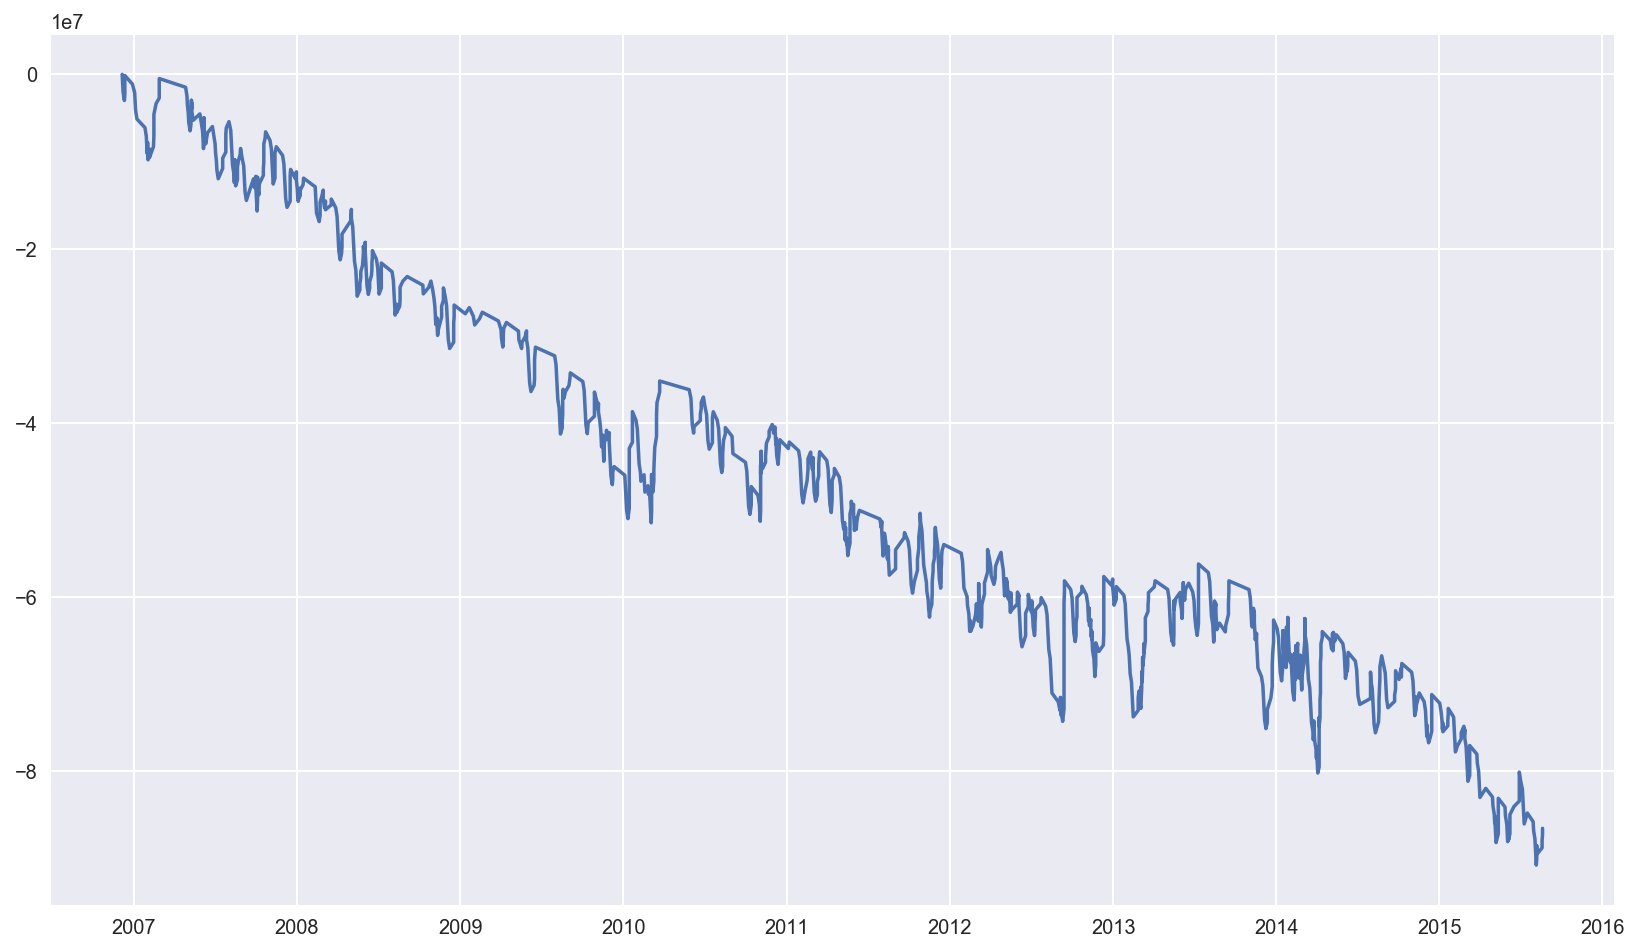

In [25]:
capital = long_straddle.initial_capital + (-bt.trade_log['totals']['cost'] * bt.trade_log['totals']['qty']).cumsum()
date = bt.trade_log['totals']['date']
plt.plot(date, capital);

Finally we run an [iron condor](https://www.investopedia.com/terms/i/ironcondor.asp).

In [26]:
# Iron Condor
iron_condor = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.PUT, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= 0.85 * schema.underlying_last)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 0.90 * schema.underlying_last) & (schema.strike <= schema.underlying_last)
leg2.exit_filter = (schema.dte <= 2)

leg3 = StrategyLeg("leg_3", schema, option_type=Type.CALL, direction=Direction.SELL)
leg3.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last) & (schema.strike <= 1.10 * schema.underlying_last)
leg3.exit_filter = (schema.dte <= 2)

leg4 = StrategyLeg("leg_4", schema, option_type=Type.PUT, direction=Direction.BUY)
leg4.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 1.15 * schema.underlying_last)
leg4.exit_filter = (schema.dte <= 2)


iron_condor.add_legs([leg1, leg2, leg3, leg4])
iron_condor.exit_thresholds = (0.25, 0.25)

In [27]:
bt = Backtest()
bt.strategy = iron_condor
bt.data = data
bt.stop_if_broke = False

In [28]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:06:15


leg_1                                                \
               contract underlying expiration type strike  cost order   
0    SPV090117P00200000        SPX 2009-01-17  put  200.0  35.0   BTO   
1    SPV090117P00200000        SPX 2009-01-17  put  200.0  -0.0   STC   
2    SPV090117P00300000        SPX 2009-01-17  put  300.0  40.0   BTO   
3    SPV090117P00300000        SPX 2009-01-17  put  300.0  -5.0   STC   
4    SPV090117P00200000        SPX 2009-01-17  put  200.0  40.0   BTO   
..                  ...        ...        ...  ...    ...   ...   ...   
550  SPX150821P00800000        SPX 2015-08-21  put  800.0  -0.0   STC   
551  SPX150918P00500000        SPX 2015-09-18  put  500.0  -0.0   STC   
552  SPX150918P00600000        SPX 2015-09-18  put  600.0  -0.0   STC   
553  SPX150918P00700000        SPX 2015-09-18  put  700.0  -0.0   STC   
554  SPX150918P00825000        SPX 2015-09-18  put  825.0  -0.0   STC   

                  leg_2                        ...               leg_4  \
               contract underlying expiration  ...            contract   
0    SPZ090117P00740000        SPX 2009-01-17  ...  SXB090117P00940000   
1    SPZ090117P00740000        SPX 2009-01-17  ...  SXB090117P00940000   
2    SPZ090117P00765000        SPX 2009-01-17  ...  SXB090117P00980000   
3    SPZ090117P00765000        SPX 2009-01-17  ...  SXB090117P00980000   
4    SPZ090117P00765000        SPX 2009-01-17  ...  SXB090117P00975000   
..                  ...        ...        ...  ...                 ...   
550  SPX150821P01845000        SPX 2015-08-21  ...  SPX150821P02600000   
551  SPX150918P01900000        SPX 2015-09-18  ...  SPX150918P02450000   
552  SPX150918P01895000        SPX 2015-09-18  ...  SPX150918P02500000   
553  SPX150918P01890000        SPX 2015-09-18  ...  SPX150918P02550000   
554  SPX150918P01880000        SPX 2015-09-18  ...  SPX150918P02400000   

                                                        totals         \
    underlying expiration type  strike     cost order     cost    qty   
0          SPX 2009-01-17  put   940.0  14740.0   BTO   5325.0  187.0   
1          SPX 2009-01-17  put   940.0 -11750.0   STC  -1520.0  187.0   
2          SPX 2009-01-17  put   980.0  14870.0   BTO   4830.0  207.0   
3          SPX 2009-01-17  put   980.0 -13250.0   STC  -2315.0  207.0   
4          SPX 2009-01-17  put   975.0  14870.0   BTO   4880.0  204.0   
..         ...        ...  ...     ...      ...   ...      ...    ...   
550        SPX 2015-08-21  put  2600.0 -52120.0   STC -49045.0   19.0   
551        SPX 2015-09-18  put  2450.0 -41660.0   STC -39960.0   31.0   
552        SPX 2015-09-18  put  2500.0 -52480.0   STC -49100.0   27.0   
553        SPX 2015-09-18  put  2550.0 -57480.0   STC -54100.0   23.0   
554        SPX 2015-09-18  put  2400.0 -42490.0   STC -39160.0   34.0   

                
          date  
0   2008-12-01  
1   2008-12-02  
2   2008-12-02  
3   2008-12-03  
4   2008-12-04  
..         ...  
550 2015-08-19  
551 2015-08-20  
552 2015-08-21  
553 2015-08-21  
554 2015-08-21  

[555 rows x 31 columns]

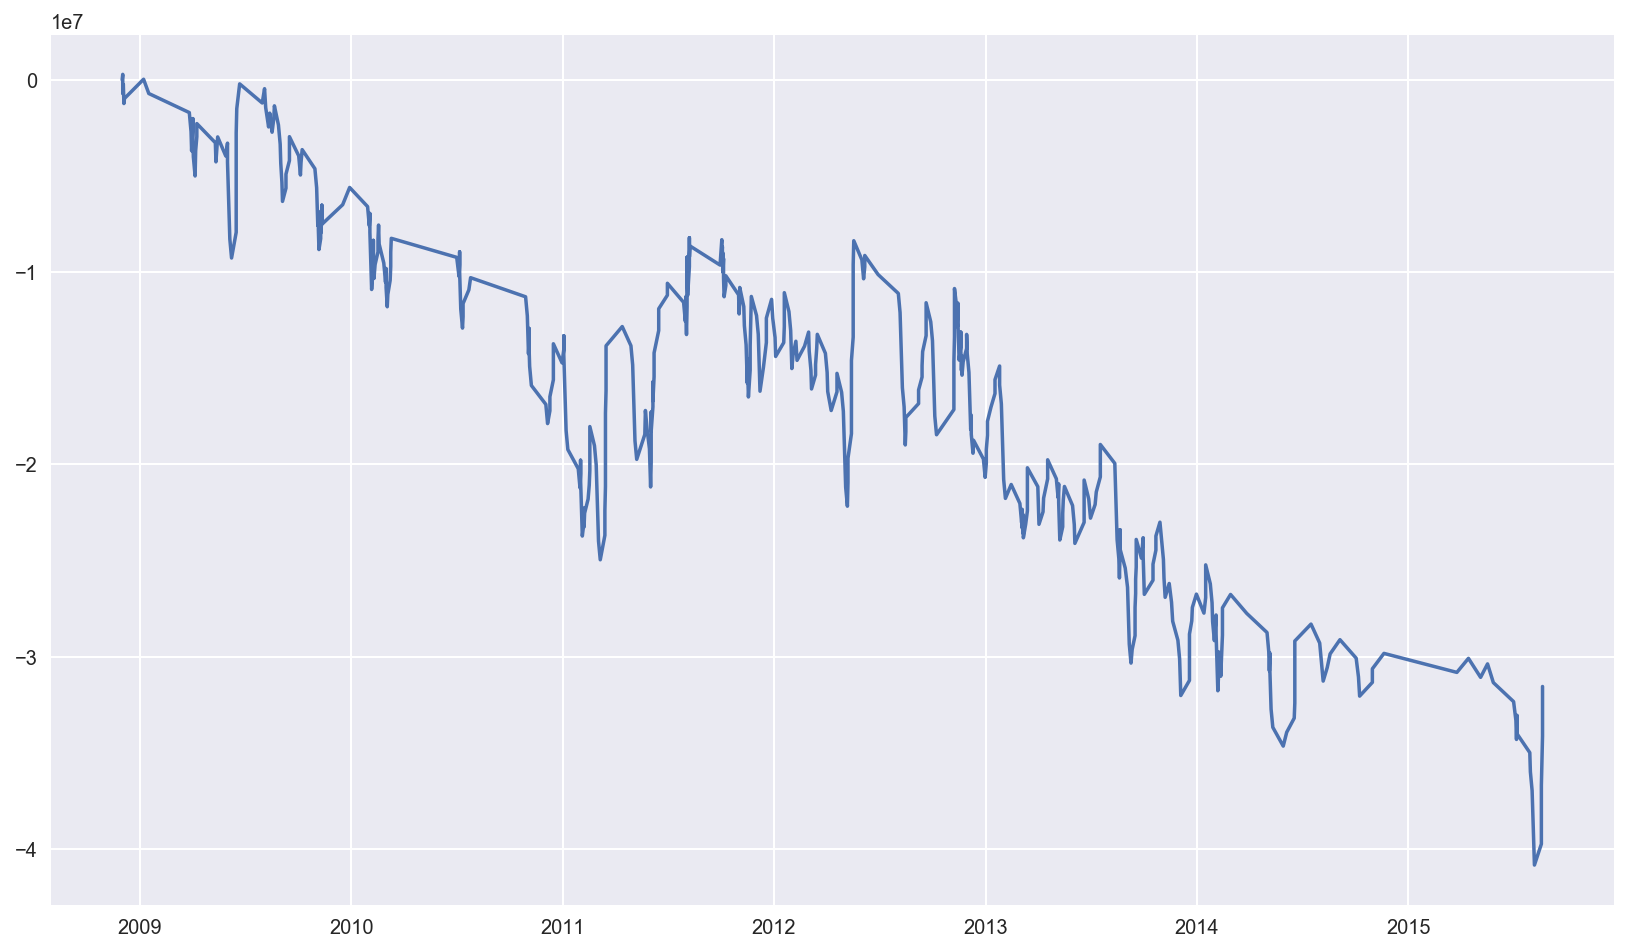

In [29]:
capital = iron_condor.initial_capital + (-bt.trade_log['totals']['cost'] * bt.trade_log['totals']['qty']).cumsum()
date = bt.trade_log['totals']['date']
plt.plot(date, capital);

To run the backtest monthly, use the boolean parameter *monthly* on the *run* method (False by default).

In [30]:
# Short ATM straddle (monthly)
short_straddle_monthly = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 60)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 60)

short_straddle_monthly.add_legs([leg1, leg2])
# Exit thresholds: none
short_straddle_monthly.exit_thresholds = (float('inf'), float('inf'))

In [31]:
bt = Backtest()
bt.strategy = short_straddle_monthly
bt.data = data
bt.stop_if_broke = False

In [32]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11


leg_1                                                     \
               contract underlying expiration  type  strike     cost order   
0    SXY070217C01345000        SPX 2007-02-17  call  1345.0  -8530.0   STO   
1    SXY070217C01345000        SPX 2007-02-17  call  1345.0   8200.0   BTC   
2    SXY070317C01355000        SPX 2007-03-17  call  1355.0  -7920.0   STO   
3    SXY070317C01355000        SPX 2007-03-17  call  1355.0   9860.0   BTC   
4    SXZ070421C01485000        SPX 2007-04-21  call  1485.0  -1140.0   STO   
..                  ...        ...        ...   ...     ...      ...   ...   
154  SPX150821C02010000        SPX 2015-08-21  call  2010.0 -11900.0   STO   
155  SPX150821C02010000        SPX 2015-08-21  call  2010.0   8940.0   BTC   
156  SPX150918C01975000        SPX 2015-09-18  call  1975.0 -12230.0   STO   
157  SPX150918C01975000        SPX 2015-09-18  call  1975.0  12720.0   BTC   
158  SPX151016C02000000        SPX 2015-10-16  call  2000.0 -11020.0   STO   

                  leg_2                                                   \
               contract underlying expiration type  strike    cost order   
0    SXY070217P01345000        SPX 2007-02-17  put  1345.0  -790.0   STO   
1    SXY070217P01345000        SPX 2007-02-17  put  1345.0   540.0   BTC   
2    SXY070317P01355000        SPX 2007-03-17  put  1355.0 -1030.0   STO   
3    SXY070317P01355000        SPX 2007-03-17  put  1355.0   280.0   BTC   
4    SXY070421P01375000        SPX 2007-04-21  put  1375.0  -690.0   STO   
..                  ...        ...        ...  ...     ...     ...   ...   
154  SPX150821P02010000        SPX 2015-08-21  put  2010.0 -2440.0   STO   
155  SPX150821P02010000        SPX 2015-08-21  put  2010.0  2650.0   BTC   
156  SPX150918P02015000        SPX 2015-09-18  put  2015.0 -3720.0   STO   
157  SPX150918P02015000        SPX 2015-09-18  put  2015.0  1560.0   BTC   
158  SPX151016P02000000        SPX 2015-10-16  put  2000.0 -2160.0   STO   

      totals                    
        cost    qty       date  
0    -9320.0  108.0 2006-12-01  
1     8740.0  108.0 2007-01-01  
2    -8950.0  112.0 2007-01-01  
3    10140.0  112.0 2007-02-01  
4    -1830.0  547.0 2007-02-01  
..       ...    ...        ...  
154 -14340.0   70.0 2015-06-01  
155  11590.0   70.0 2015-07-01  
156 -15950.0   63.0 2015-07-01  
157  14280.0   63.0 2015-08-01  
158 -13180.0   76.0 2015-08-01  

[159 rows x 17 columns]

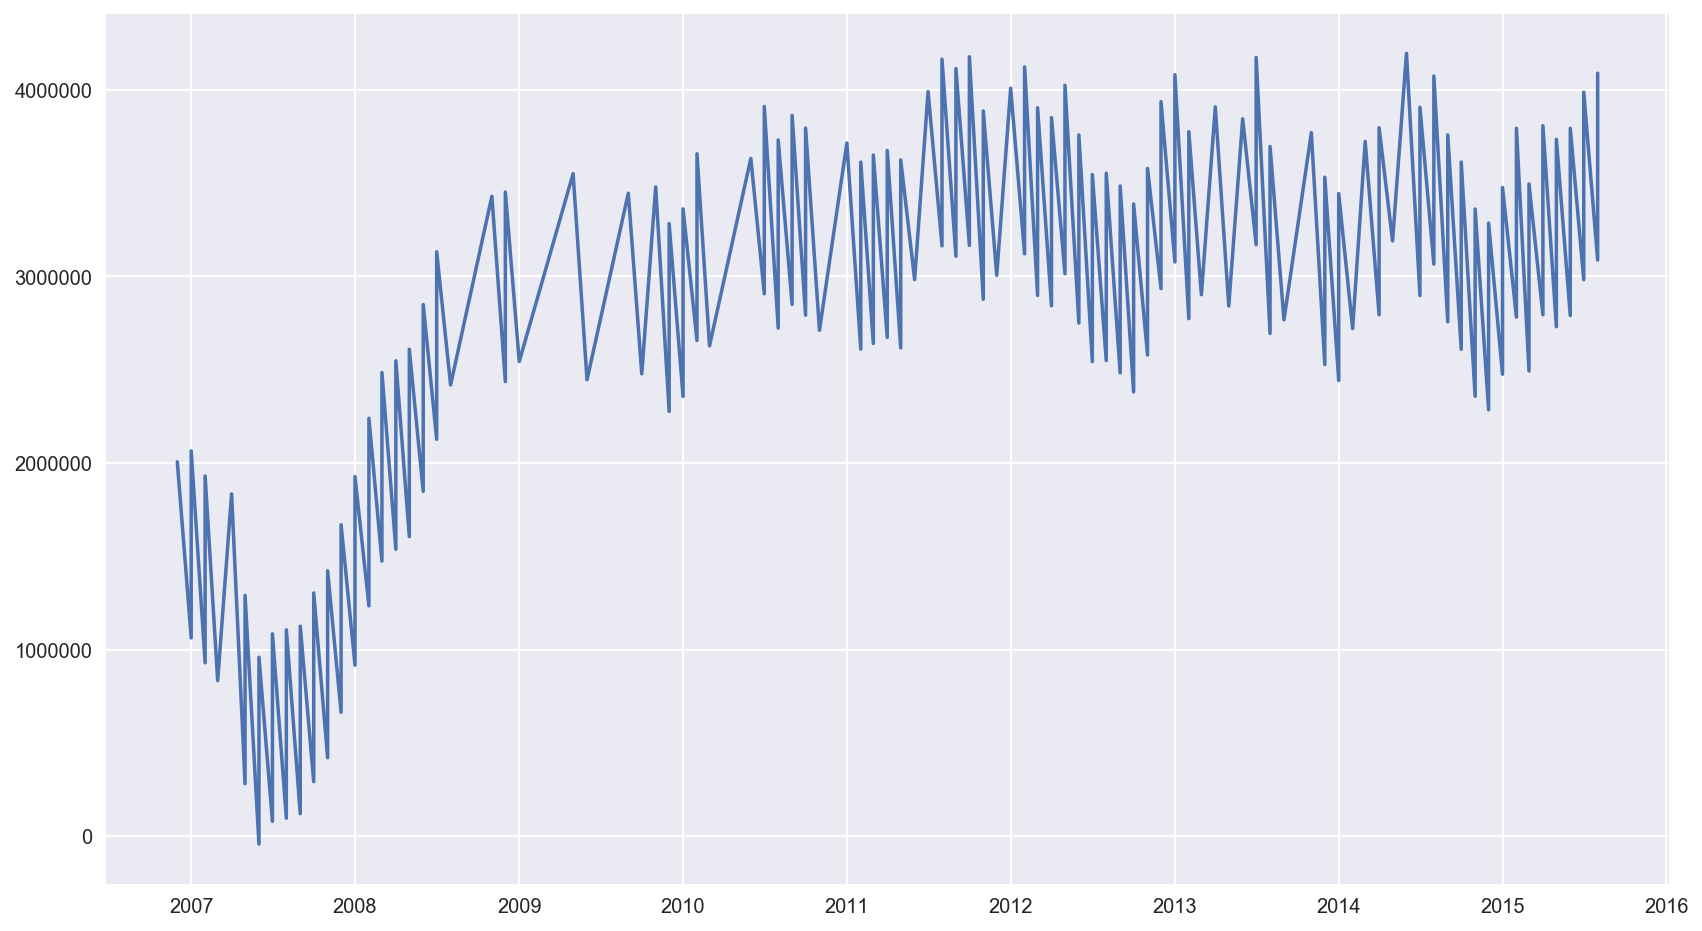

In [33]:
capital = short_straddle_monthly.initial_capital + (-bt.trade_log['totals']['cost'] * bt.trade_log['totals']['qty']).cumsum()
date = bt.trade_log['totals']['date']
plt.plot(date, capital);

We also have a class that parametrizes the strangle (long or short). Straddles are a special case of strangles when the *OTM* percentage is (close to) zero.

In [34]:
from backtester.strategy import Strangle

In [35]:
strangle = Strangle(schema, 'long', 'SPX', dte_entry_range=(61,90), dte_exit=60, otm_pct=0, pct_tolerance=1, exit_thresholds=(float('inf'), float('inf')))

*otm_pct* is how OTM (in percentage) we want the contracts to be. For instance 3 means we pick contracts approximately 3% out of the money. This *approximately* is controlled by the parameter *pct_tolerance*. Its value is the range of *otm_pct*, so if *otm_pct* = 3 and *pct_tolerance* = 1, the contracts we choose are between 2% and 4% OTM. *otm_pct* and *pct_tolerance* are set to 0 and 1 by default.

In [36]:
bt = Backtest()
bt.strategy = strangle
bt.data = data
bt.stop_if_broke = False

In [37]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


leg_1                                                    \
               contract underlying expiration  type  strike    cost order   
0    SXZ070217C01405000        SPX 2007-02-17  call  1405.0  3960.0   BTO   
1    SXZ070217C01405000        SPX 2007-02-17  call  1405.0 -3110.0   STC   
2    SXZ070317C01410000        SPX 2007-03-17  call  1410.0  3940.0   BTO   
3    SXZ070317C01410000        SPX 2007-03-17  call  1410.0 -4700.0   STC   
4    SXZ070721C01475000        SPX 2007-07-21  call  1475.0  4870.0   BTO   
..                  ...        ...        ...   ...     ...     ...   ...   
108  SPX150821C02100000        SPX 2015-08-21  call  2100.0  5530.0   BTO   
109  SPX150821C02100000        SPX 2015-08-21  call  2100.0 -2690.0   STC   
110  SPX150918C02055000        SPX 2015-09-18  call  2055.0  6620.0   BTO   
111  SPX150918C02055000        SPX 2015-09-18  call  2055.0 -5810.0   STC   
112  SPX151016C02075000        SPX 2015-10-16  call  2075.0  5760.0   BTO   

                  leg_2                                                   \
               contract underlying expiration type  strike    cost order   
0    SXZ070217P01405000        SPX 2007-02-17  put  1405.0  2100.0   BTO   
1    SXZ070217P01405000        SPX 2007-02-17  put  1405.0 -1480.0   STC   
2    SXZ070317P01410000        SPX 2007-03-17  put  1410.0  2470.0   BTO   
3    SXZ070317P01410000        SPX 2007-03-17  put  1410.0  -680.0   STC   
4    SXZ070721P01475000        SPX 2007-07-21  put  1475.0  2570.0   BTO   
..                  ...        ...        ...  ...     ...     ...   ...   
108  SPX150821P02100000        SPX 2015-08-21  put  2100.0  5030.0   BTO   
109  SPX150821P02100000        SPX 2015-08-21  put  2100.0 -5420.0   STC   
110  SPX150918P02055000        SPX 2015-09-18  put  2055.0  5210.0   BTO   
111  SPX150918P02055000        SPX 2015-09-18  put  2055.0 -2220.0   STC   
112  SPX151016P02075000        SPX 2015-10-16  put  2075.0  4310.0   BTO   

      totals                    
        cost    qty       date  
0     6060.0  165.0 2006-12-01  
1    -4590.0  165.0 2007-01-01  
2     6410.0  156.0 2007-01-01  
3    -5380.0  156.0 2007-02-01  
4     7440.0  134.0 2007-05-01  
..       ...    ...        ...  
108  10560.0   94.0 2015-06-01  
109  -8110.0   94.0 2015-07-01  
110  11830.0   84.0 2015-07-01  
111  -8030.0   84.0 2015-08-01  
112  10070.0   99.0 2015-08-01  

[113 rows x 17 columns]

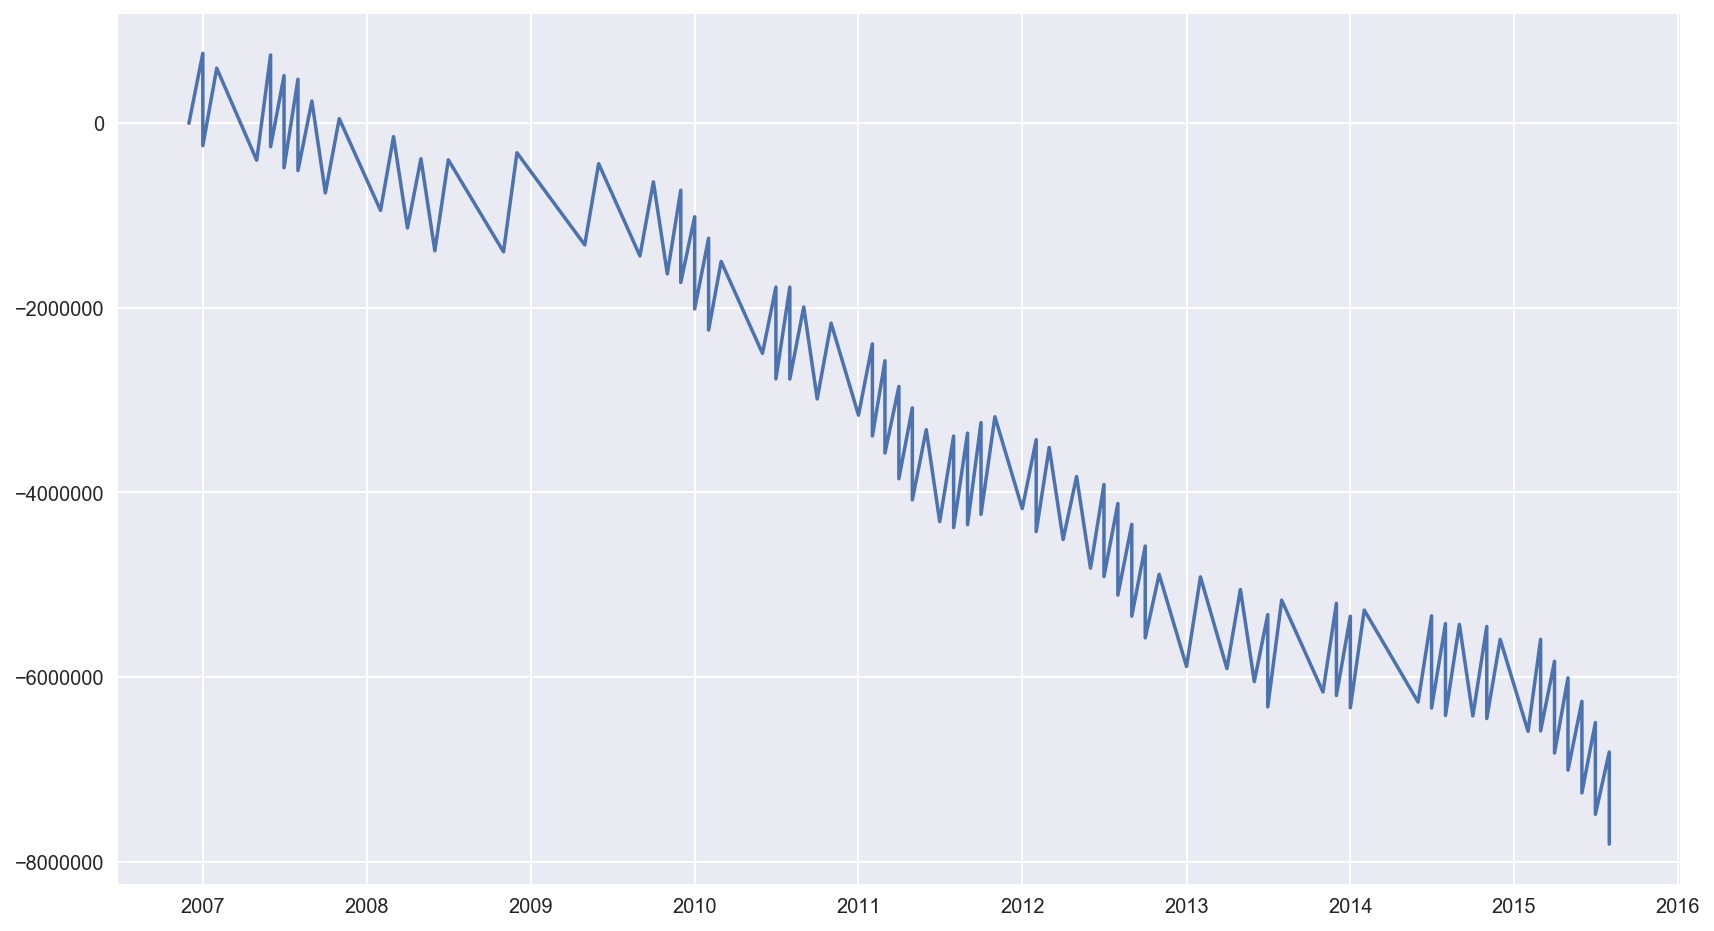

In [38]:
capital = strangle.initial_capital + (-bt.trade_log['totals']['cost'] * bt.trade_log['totals']['qty']).cumsum()
date = bt.trade_log['totals']['date']
plt.plot(date, capital);

We now run a monthly short strangle with different OTM percentages and plot the capital over time for each of them.

In [39]:
otm_percentages = [0,3,5,7,10,15,20,25,35]

In [40]:
bt = Backtest()
bt.data = data
bt.stop_if_broke = False
trade_logs = []
for otm_pct in otm_percentages:
    strangle = Strangle(schema, 'short', 'SPX', dte_entry_range=(61,90), dte_exit=60, otm_pct=otm_pct, pct_tolerance=1)
    bt.strategy = strangle
    bt.run(monthly=True)
    trade_logs.append(bt.trade_log)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:11
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09
0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


In [41]:
capitals = []
dates = []
for trade_log in trade_logs:
    capital = strangle.initial_capital + (-trade_log['totals']['cost'] * trade_log['totals']['qty']).cumsum()
    capital.index = trade_log['totals']['date']
    capitals.append(capital)

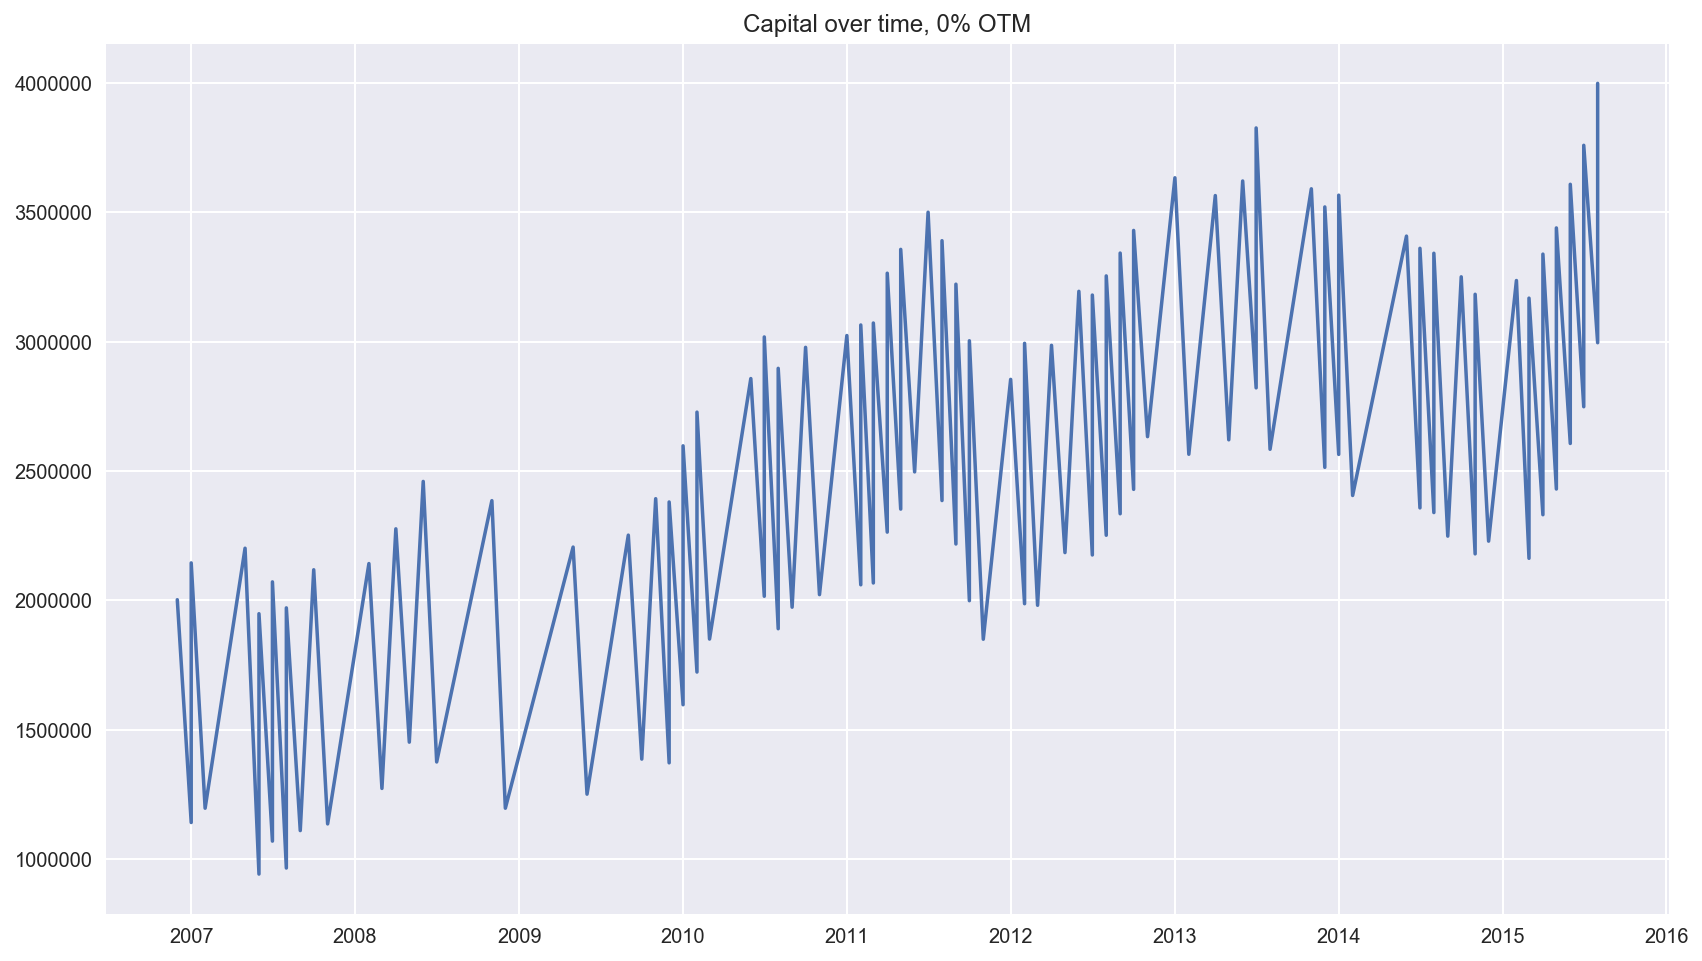

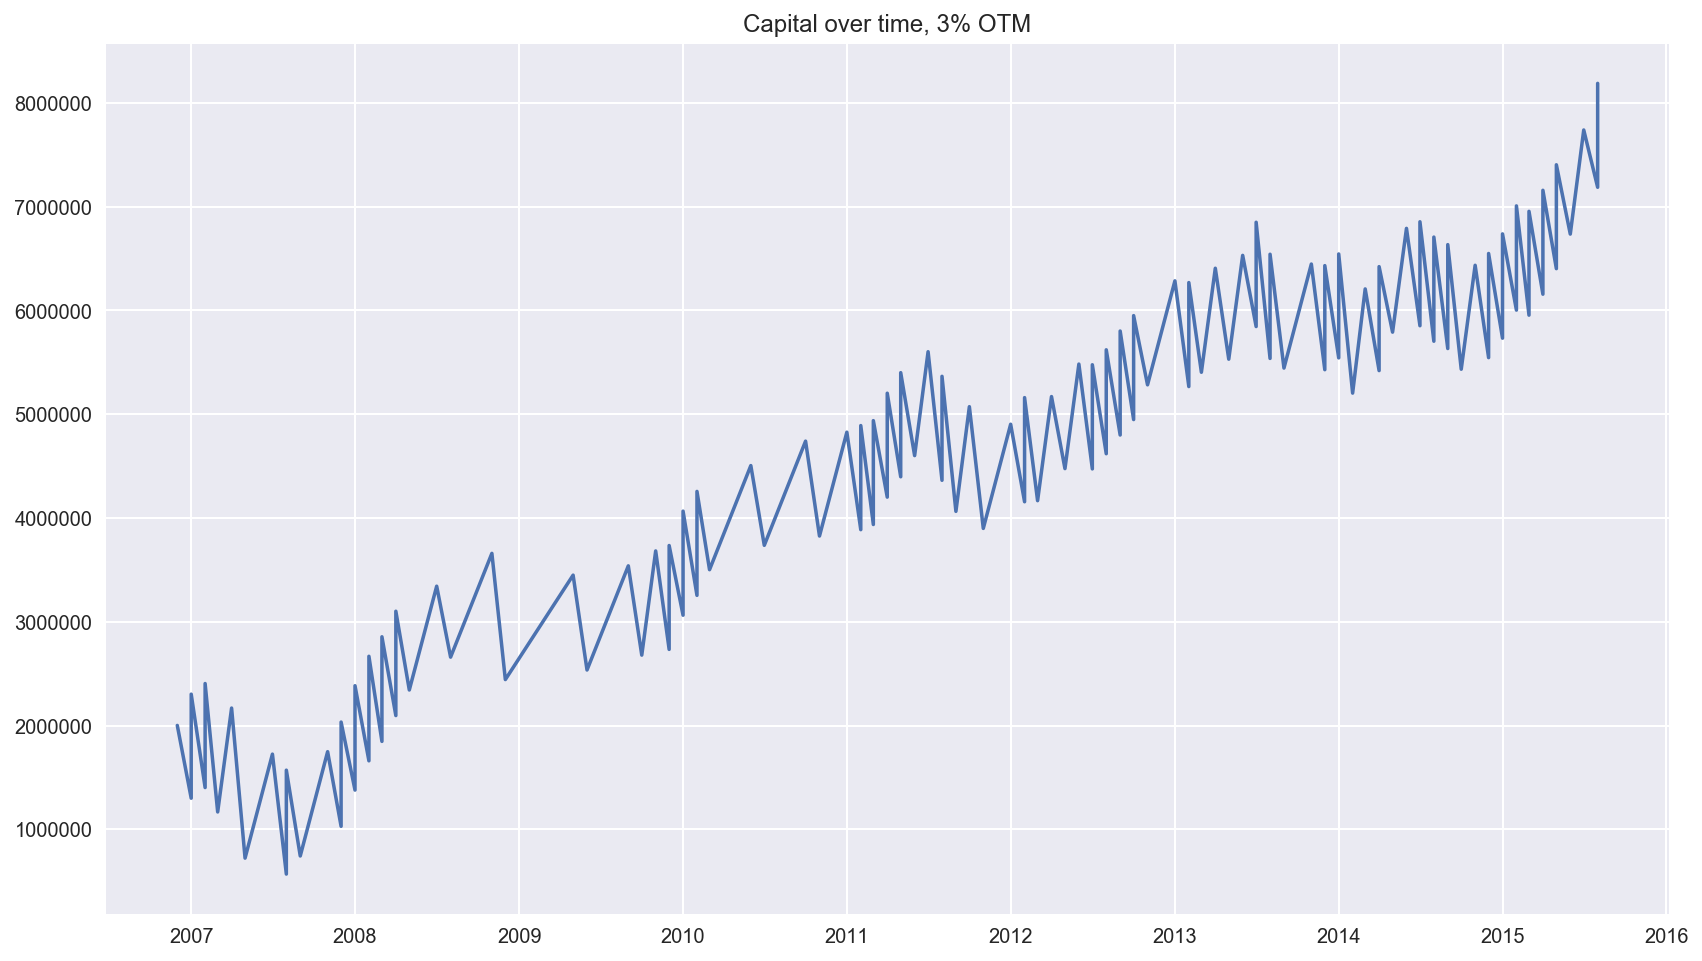

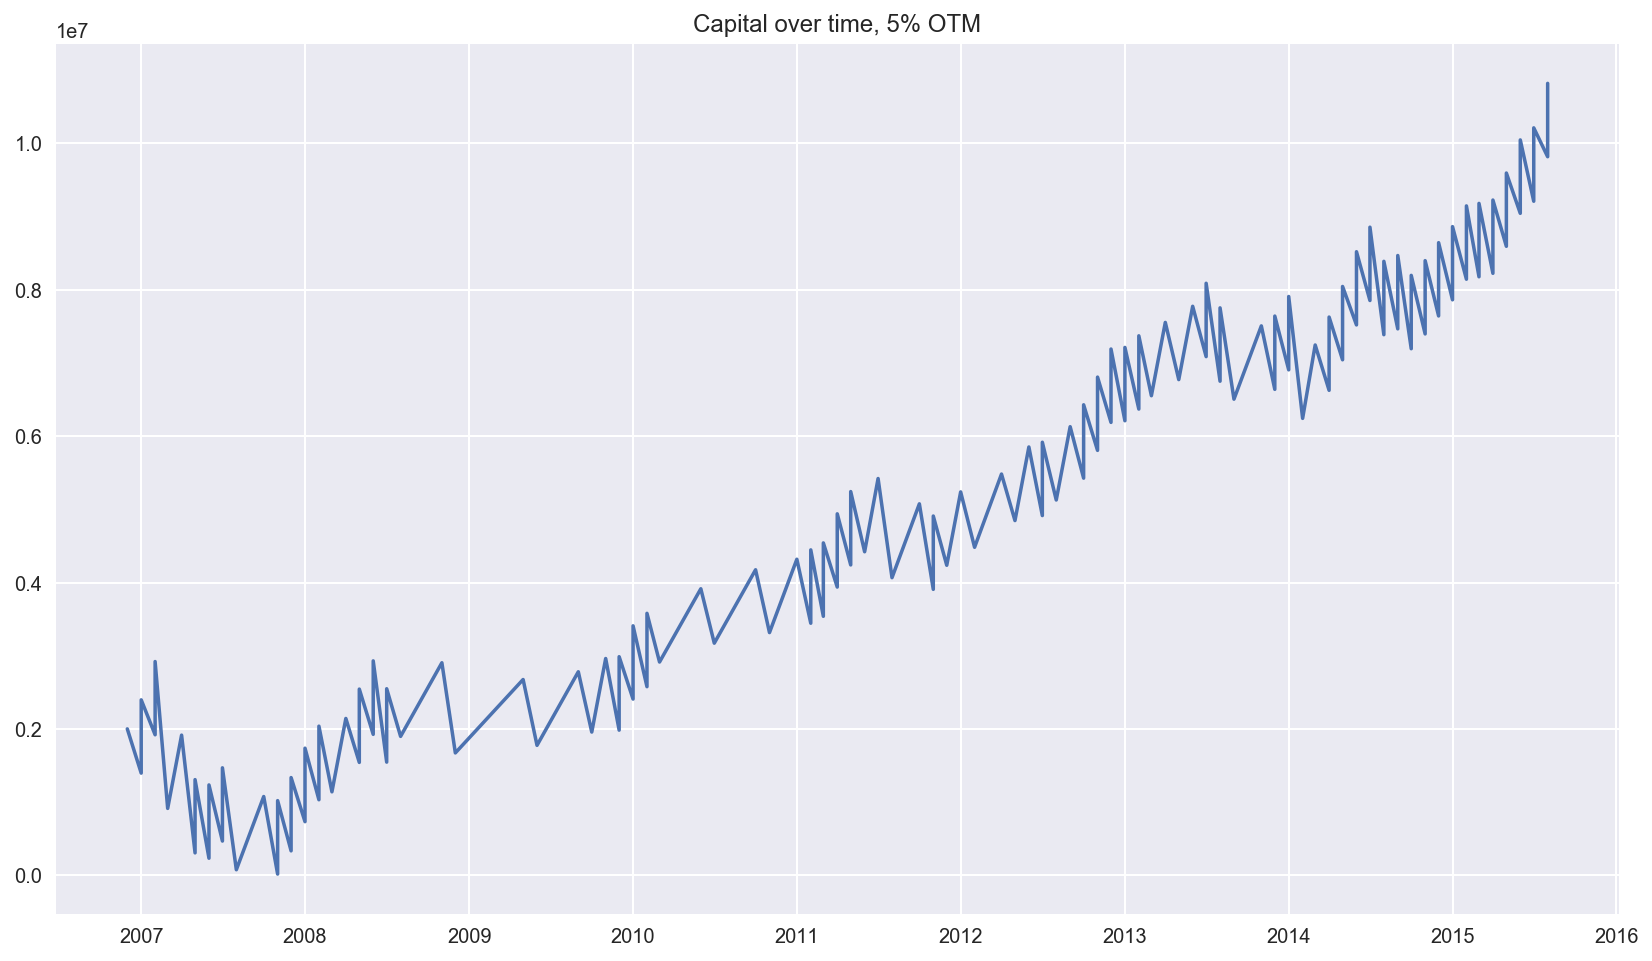

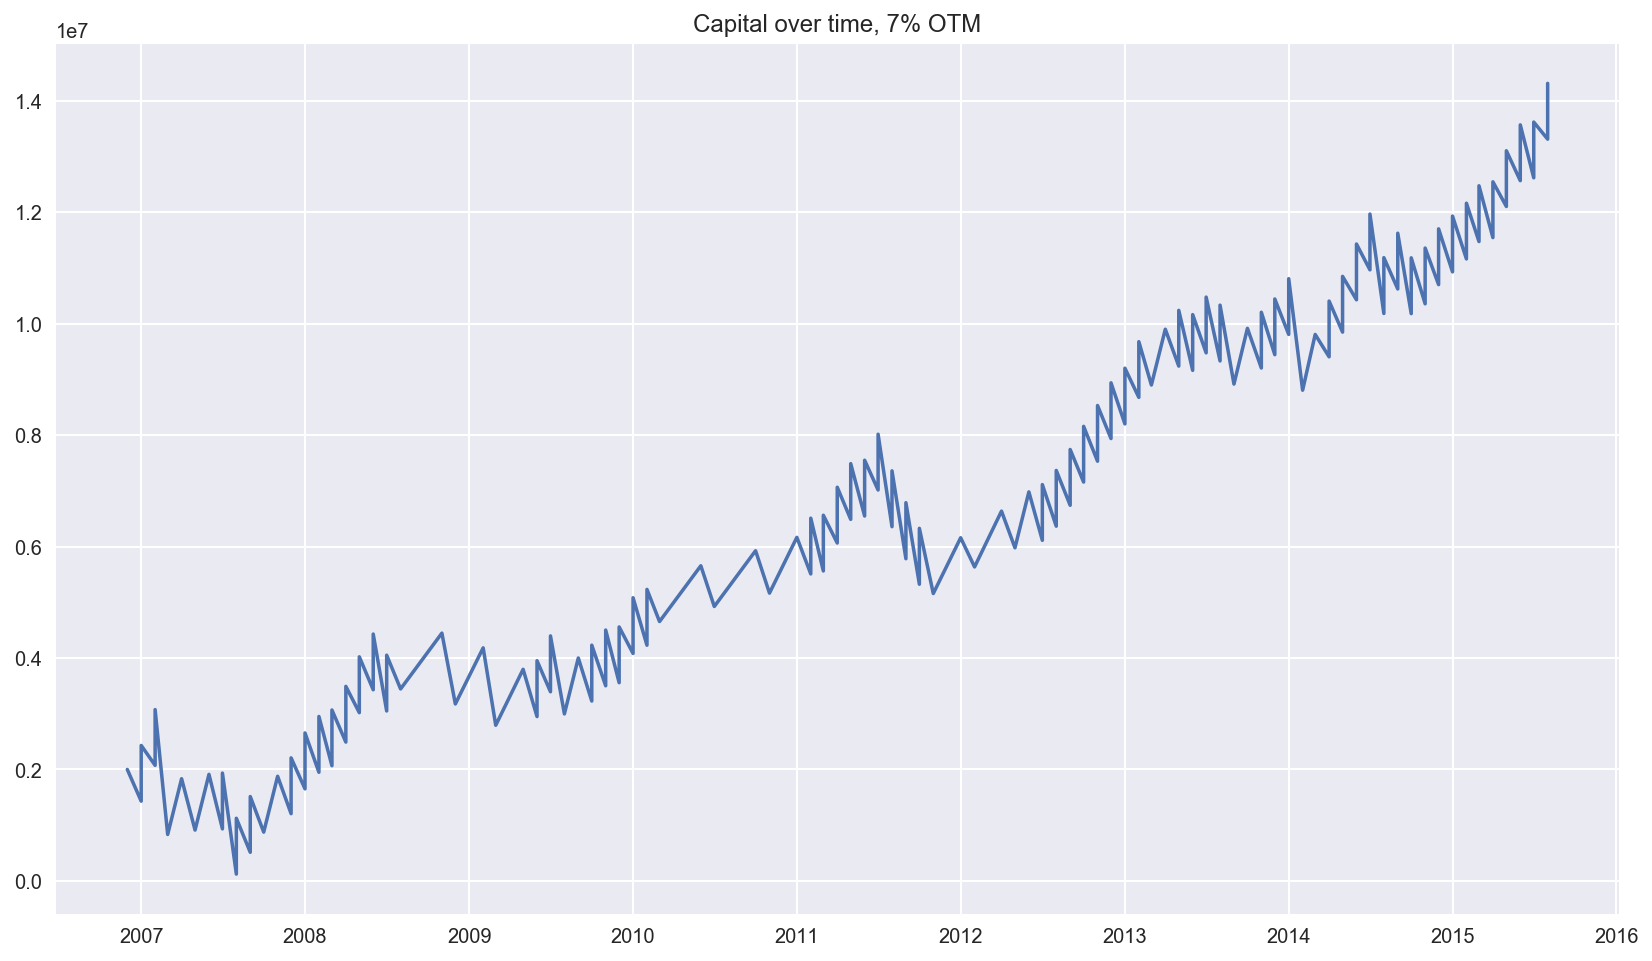

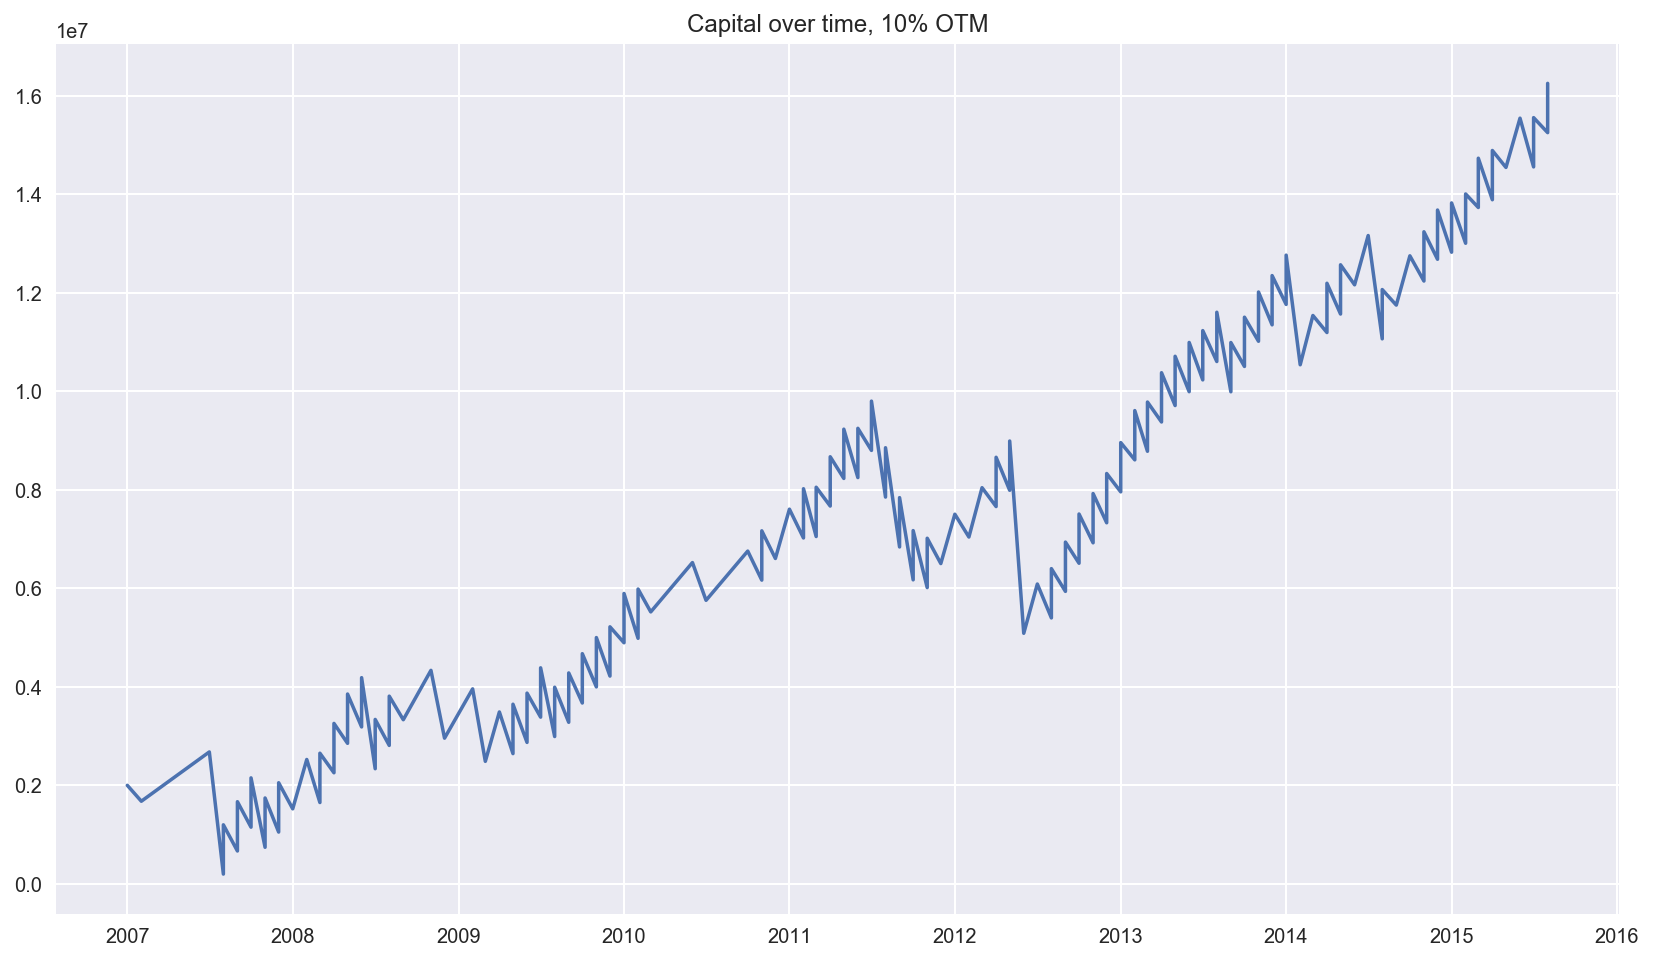

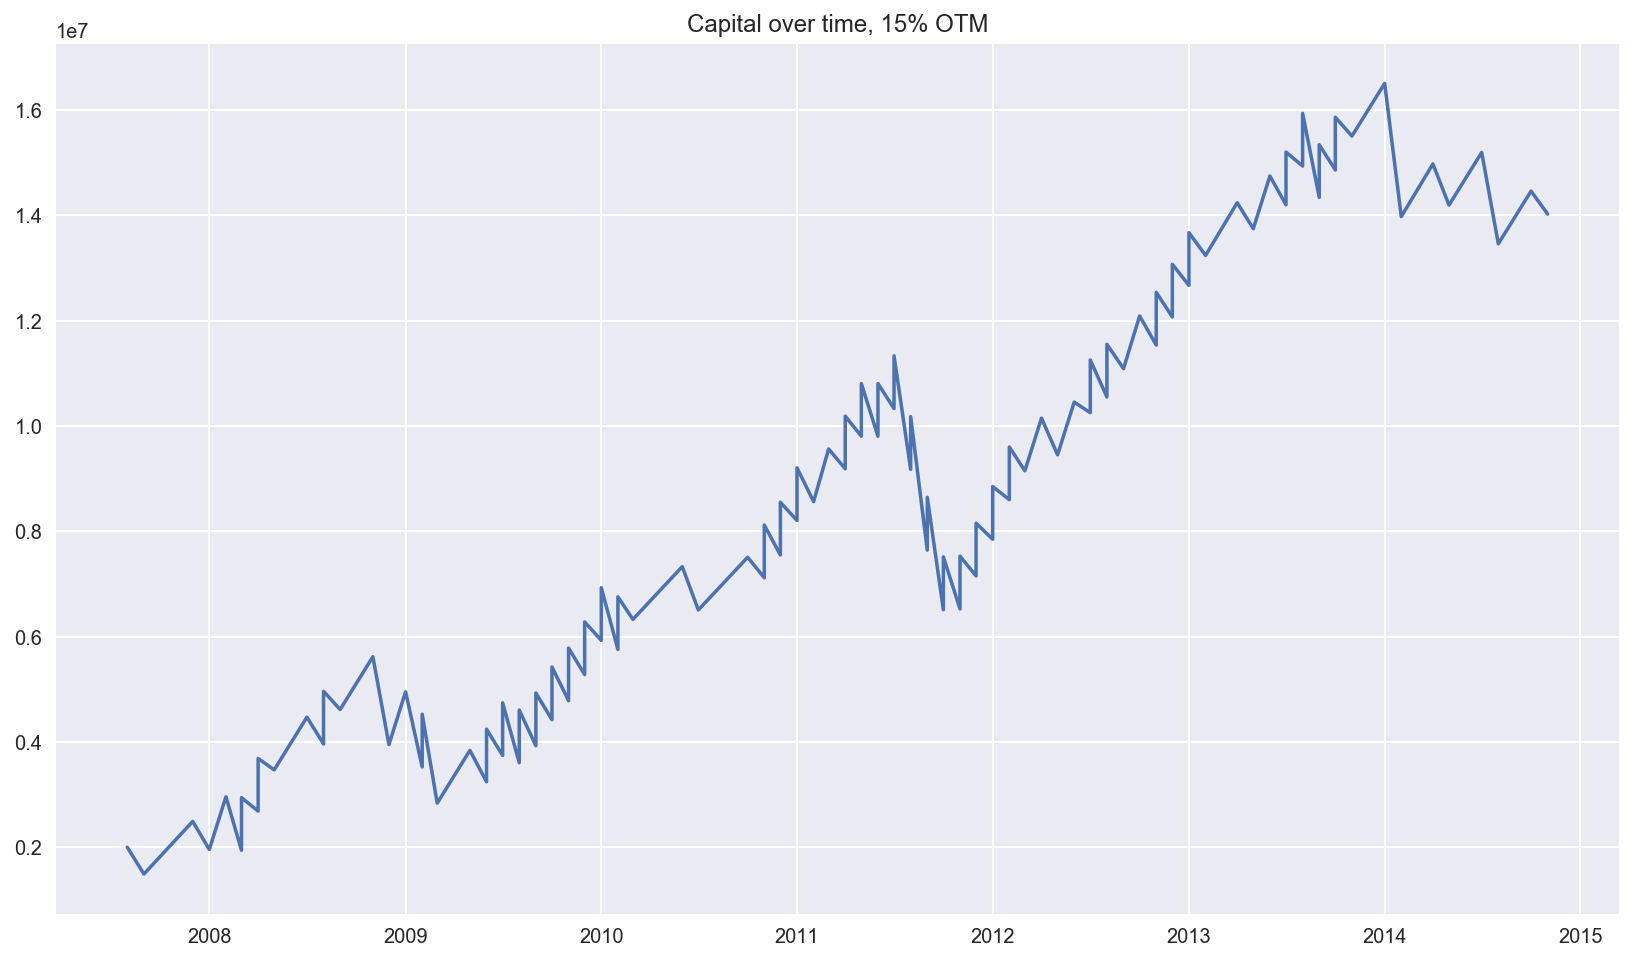

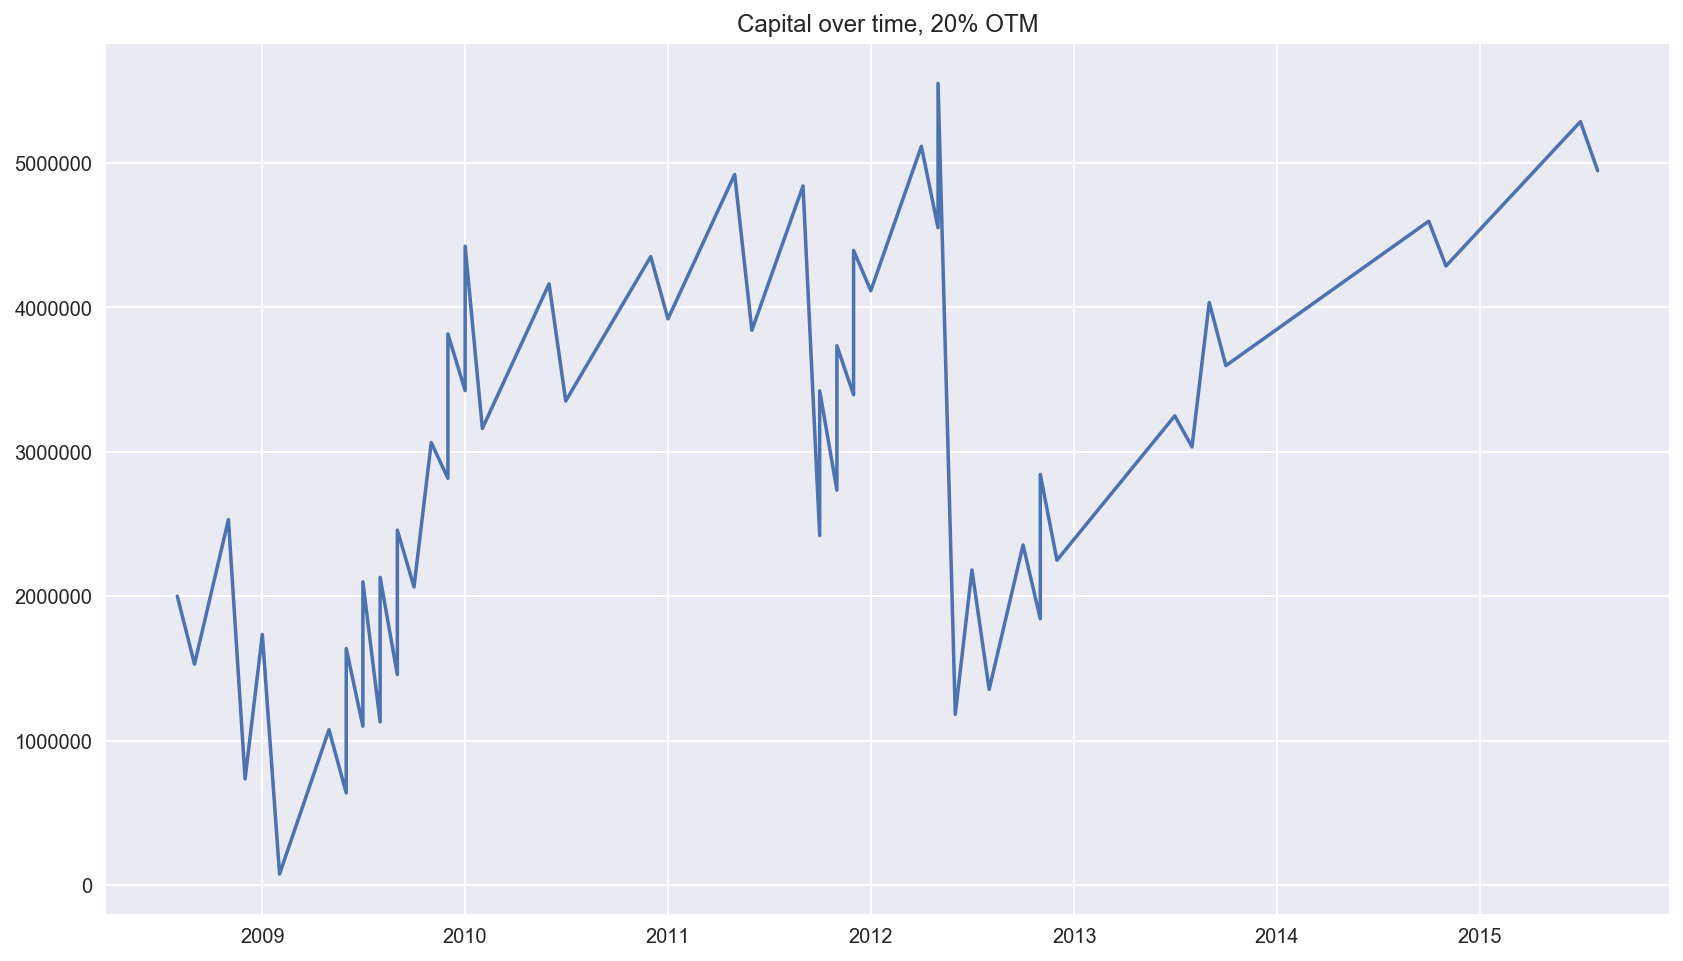

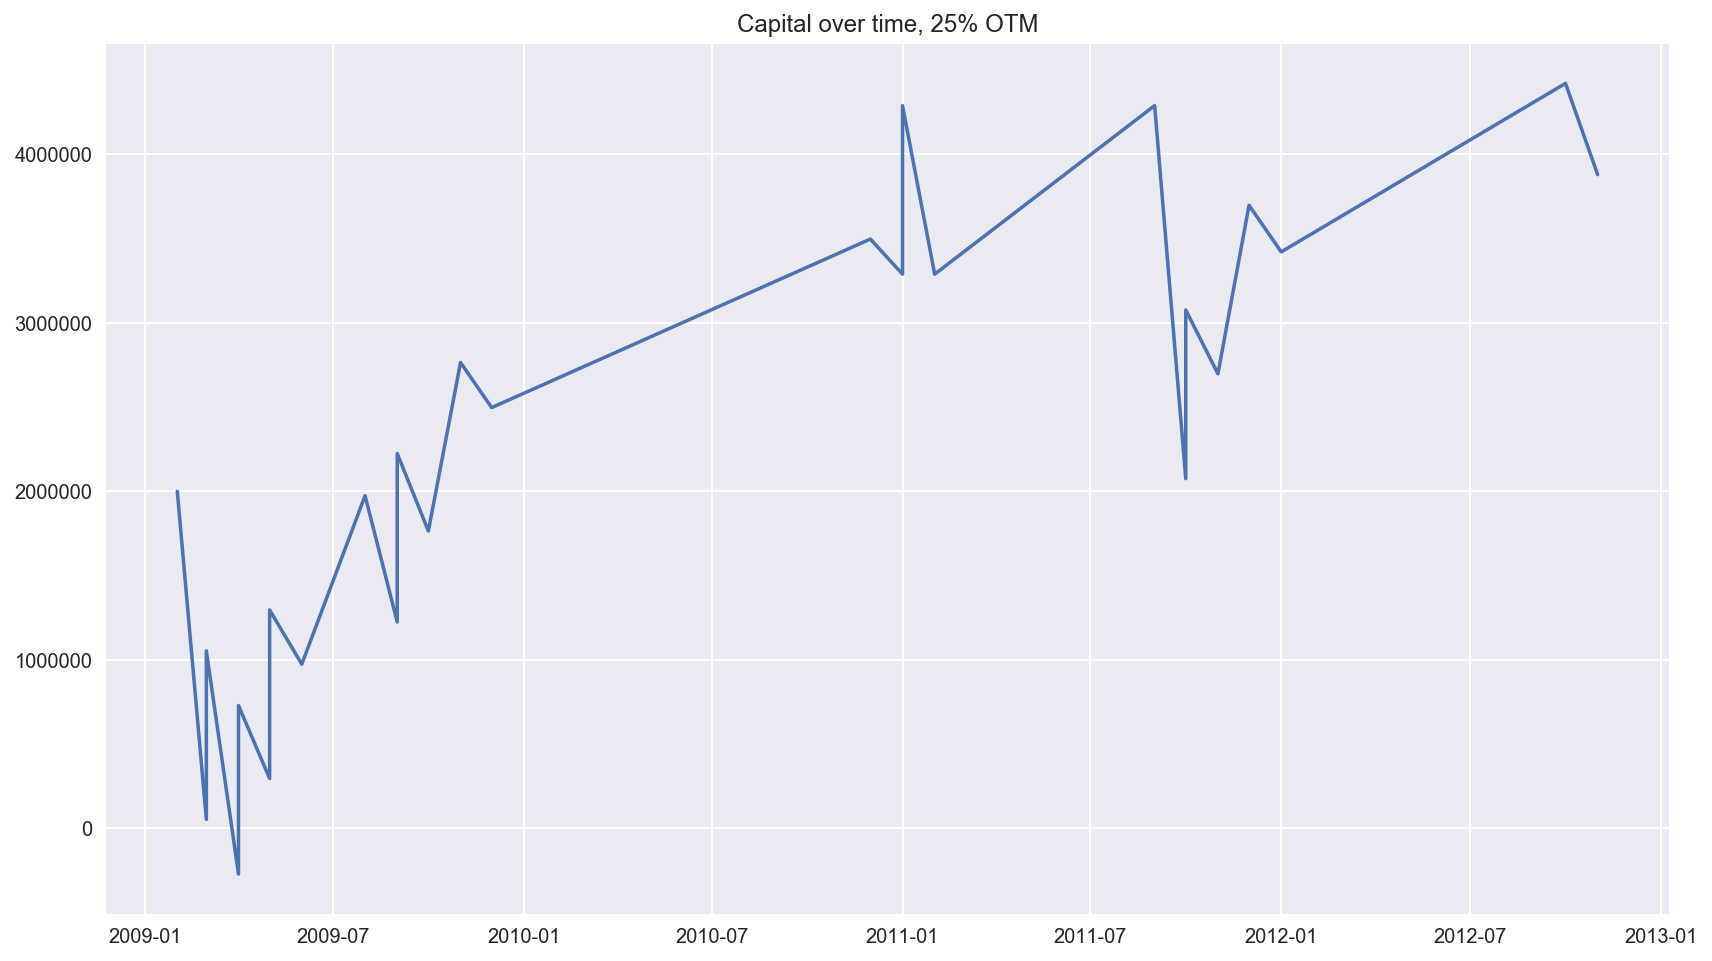

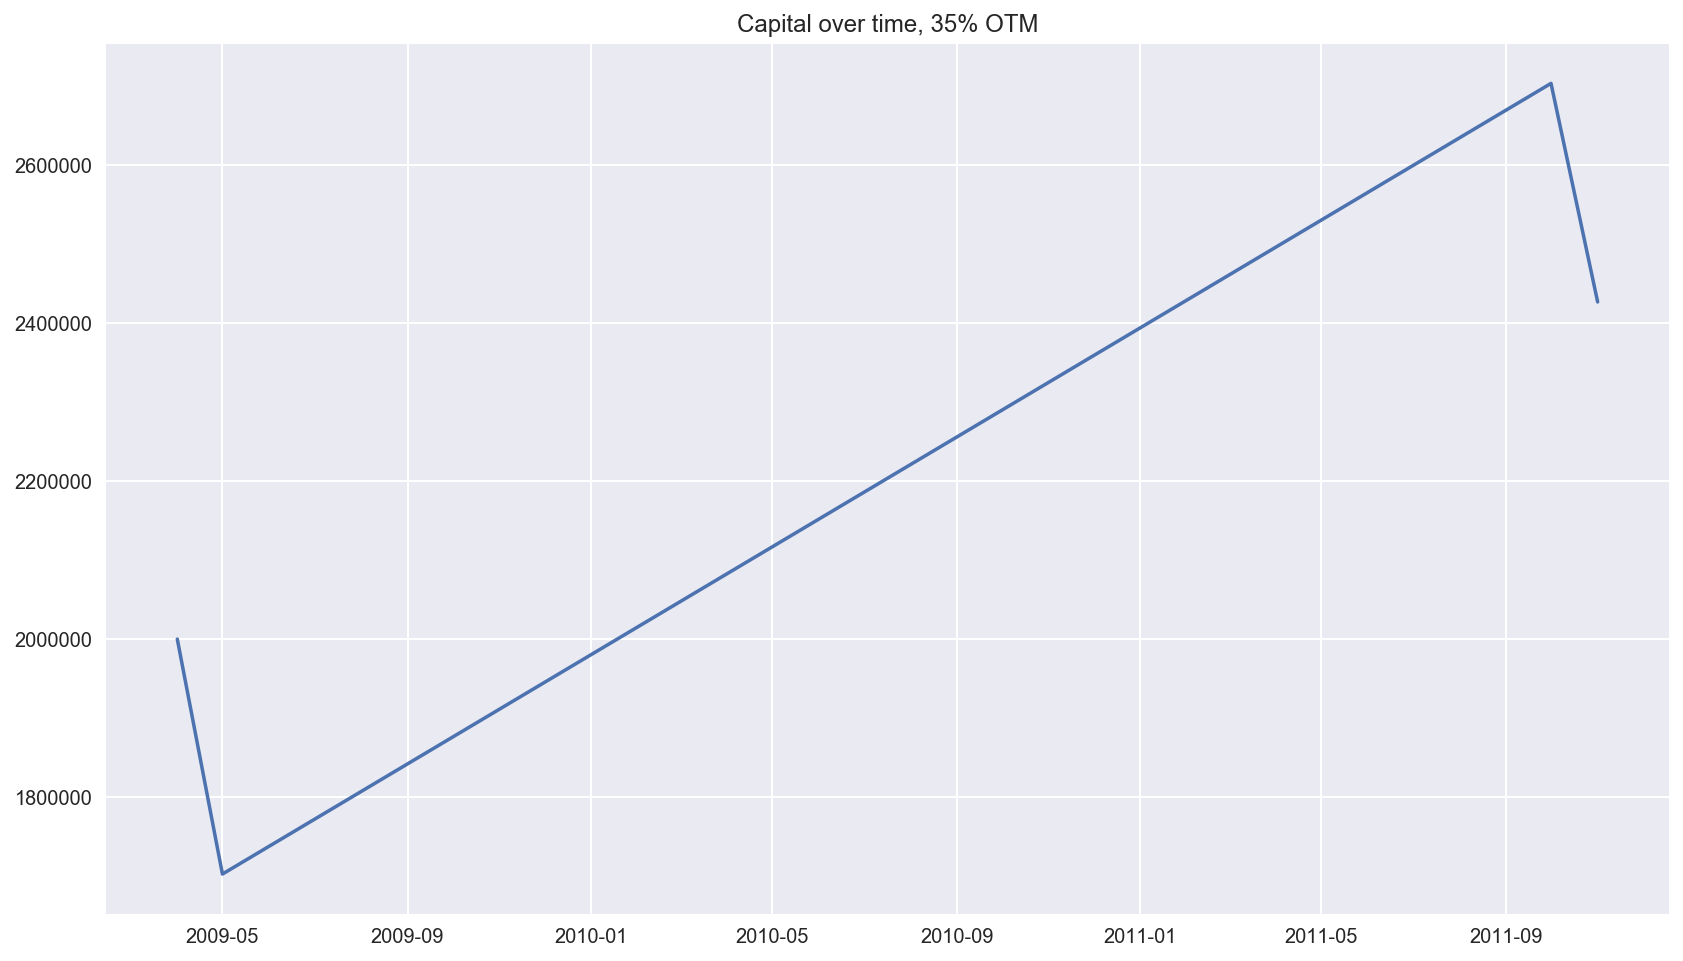

In [42]:
for i, capital in enumerate(capitals):
    plt.plot(capital)
    plt.title('Capital over time, {}% OTM'.format(otm_percentages[i]))
    plt.show()